In [1]:
from model.ctabgan import CTABGAN
from model.eval.evaluation import get_utility_metrics,stat_sim,privacy_metrics
import numpy as np
import pandas as pd
import glob
import os
import math
import optuna
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp

c:\Users\povil\miniconda3\envs\py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Merge csv

In [7]:
csv_files = glob.glob(os.path.join("Real_Datasets/original", "*.csv"))

df = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

df.to_csv("Real_Datasets/merged.csv", index=False)

In [8]:
real_path = "Real_Datasets/merged.csv"
fake_path = "Fake_Datasets/fake.csv"
fake_best_path = "Fake_Datasets/fake_best.csv"

In [26]:
df = pd.read_csv(real_path)

Clean NaNs

In [ ]:
def clean_by_nan_threshold(csv_path, column_nan_threshold=0.5):
    df = pd.read_csv(csv_path)

    threshold = int(len(df) * column_nan_threshold)
    df = df.dropna(axis=1, thresh=len(df) - threshold)

    df_cleaned = df.dropna()

    print(f"Remaining columns: {df_cleaned.shape[1]}")
    print(f"Remaining rows: {df_cleaned.shape[0]}")

    return df_cleaned

df = clean_by_nan_threshold(real_path)

Remaining columns: 31
Remaining rows: 16173222
Percentage of complete rows: 84.84%
Dropping rows with NaNs
Remaining rows: 16173222


Clean inf

In [31]:
df["Label"] = (df["Label"] != 0).astype(int)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

print(f"Remaining rows: {df.shape[0]}")

Remaining rows: 16137183


Trim low correlations columns

In [39]:
correlations = df.corr()["Label"].drop("Label")
columns_to_keep = correlations[correlations.abs() >= 0.1].index.tolist()
columns_to_keep.append("Label")
df = df[columns_to_keep]

In [36]:
def detect_column_types(df, categorical_threshold=100):
    integer_columns = []
    categorical_columns = []

    for col in df.columns:
        series = df[col].dropna()

        if series.empty:
            continue

        n_unique = series.nunique()

        if series.dtype == 'object' or n_unique <= categorical_threshold:
            categorical_columns.append(col)
            continue

        if pd.api.types.is_numeric_dtype(series):
            if np.all(series.apply(lambda x: float(x).is_integer())):
                integer_columns.append(col)

    return {
        "integer_columns": integer_columns,
        "categorical_columns": categorical_columns
    }

In [41]:
column_types = detect_column_types(df)
print("Integer columns:", column_types["integer_columns"])
print("Categorical columns:", column_types["categorical_columns"])

categoricals = column_types["categorical_columns"]
integer_columns = column_types["integer_columns"]

Integer columns: ['Min Packet Length', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward']
Categorical columns: ['ACK Flag Count', 'min_seg_size_forward', 'Label']


In [40]:
df.to_csv("Real_Datasets/cleaned.csv", index=False)

In [42]:
df = pd.read_csv("Real_Datasets/cleaned.csv", nrows=2000)
df.to_csv("Real_Datasets/trimmed.csv", index=False)
real_path = "Real_Datasets/trimmed.csv"

In [43]:
synthesizer =  CTABGAN(raw_csv_path = real_path,
                 test_ratio = 0.20,
                 categorical_columns = categoricals, 
                 log_columns = [],
                 mixed_columns= {},
                 general_columns = [],
                 non_categorical_columns = [],
                 integer_columns = integer_columns,
                 problem_type= {"Classification": 'Label'},
                 epochs=10,
                 batch_size=64) 

In [44]:
synthesizer.fit()
syn = synthesizer.generate_samples()
syn.to_csv(fake_path, index= False)

100%|██████████| 10/10 [00:33<00:00,  3.35s/it]


Finished training in 34.02523756027222  seconds.


In [45]:
classifiers_list = ["lr","dt","rf","mlp"]
result_mat = get_utility_metrics(real_path,[fake_path],"MinMax",classifiers_list, test_ratio = 0.20)

result_df  = pd.DataFrame(result_mat,columns=["Acc","AUC","F1_Score"])
result_df.index = classifiers_list
result_df

,Acc,AUC,F1_Score
lr,11.00,0.194329,0.423932
dt,22.00,0.364678,0.374663
rf,12.25,0.221771,0.198011
mlp,11.75,0.345382,0.441863


In [46]:
stat_res = stat_sim(real_path,fake_path,categoricals)


stat_columns = ["Average WD (Continuous Columns)","Average JSD (Categorical Columns)","Correlation Distance"]
stat_results = pd.DataFrame(np.array(stat_res).reshape(1,3),columns=stat_columns)
stat_results

,Average WD (Continuous Columns),Average JSD (Categorical Columns),Correlation Distance
0,0.037415,0.139432,3.270774


In [47]:
priv_res = privacy_metrics(real_path,fake_path)
    
privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
privacy_results = pd.DataFrame(np.array(priv_res).reshape(1,6),columns=privacy_columns)
privacy_results

,DCR between Real and Fake (5th perc),DCR within Real(5th perc),DCR within Fake (5th perc),NNDR between Real and Fake (5th perc),NNDR within Real (5th perc),NNDR within Fake (5th perc)
0,0.908198,0.000002,0.303558,0.525835,0.010246,0.403676


In [52]:
def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    class_dim = trial.suggest_categorical("class_dim", [(64,64), (128,128)])
    random_dim = trial.suggest_int("random_dim", 64, 200)
    num_channels = trial.suggest_categorical("num_channels", [32, 64, 128])

    synthesizer = CTABGAN(
        raw_csv_path=real_path,
        test_ratio = 0.20,
        categorical_columns = categoricals, 
        log_columns = [],
        mixed_columns= {},
        general_columns = [],
        non_categorical_columns = [],
        integer_columns = integer_columns,
        problem_type= {"Classification": 'Label'},
        epochs=10,
        batch_size=batch_size,
        class_dim=class_dim,
        random_dim=random_dim,
        num_channels=num_channels
    )

    synthesizer.fit()
    syn = synthesizer.generate_samples()

    temp_path = "tmp_synth.csv"
    syn.to_csv(temp_path, index=False)

    util_scores = get_utility_metrics(real_path, [temp_path], "MinMax", ["lr"])[0]
    stat_scores = stat_sim(real_path, temp_path, categoricals)

    auc, f1 = util_scores[1], util_scores[2]
    jsd = stat_scores[1]
    corr = stat_scores[2]
    score = auc + f1 - 0.5 * jsd - 0.25 * abs(corr)

    return score

In [53]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=3)
study = optuna.create_study(direction="maximize", study_name="ctabgan_optimization", pruner=pruner)

[I 2025-06-14 15:57:11,904] A new study created in memory with name: ctabgan_optimization


In [54]:
study.optimize(objective, n_trials=15)

100%|██████████| 10/10 [00:55<00:00,  5.52s/it]


Finished training in 55.72002410888672  seconds.


[I 2025-06-14 15:58:27,819] Trial 0 finished with value: -0.14580686936291254 and parameters: {'batch_size': 256, 'class_dim': (128, 128), 'random_dim': 169, 'num_channels': 128}. Best is trial 0 with value: -0.14580686936291254.
100%|██████████| 10/10 [00:14<00:00,  1.45s/it]


Finished training in 15.116214752197266  seconds.


[I 2025-06-14 15:58:43,458] Trial 1 finished with value: -0.09436259404849867 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 83, 'num_channels': 32}. Best is trial 1 with value: -0.09436259404849867.
100%|██████████| 10/10 [00:21<00:00,  2.19s/it]


Finished training in 22.37086844444275  seconds.


[I 2025-06-14 15:59:06,663] Trial 2 finished with value: -0.25143209167574443 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 188, 'num_channels': 64}. Best is trial 1 with value: -0.09436259404849867.
100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


Finished training in 11.124003410339355  seconds.


[I 2025-06-14 15:59:19,274] Trial 3 finished with value: -0.3594687814382328 and parameters: {'batch_size': 256, 'class_dim': (128, 128), 'random_dim': 161, 'num_channels': 32}. Best is trial 1 with value: -0.09436259404849867.
100%|██████████| 10/10 [00:31<00:00,  3.18s/it]


Finished training in 32.276503801345825  seconds.


[I 2025-06-14 15:59:53,437] Trial 4 finished with value: -0.4147012275122001 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 104, 'num_channels': 64}. Best is trial 1 with value: -0.09436259404849867.
100%|██████████| 10/10 [00:32<00:00,  3.22s/it]


Finished training in 32.746888399124146  seconds.


[I 2025-06-14 16:00:27,143] Trial 5 finished with value: 0.03727932739204243 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 158, 'num_channels': 64}. Best is trial 5 with value: 0.03727932739204243.
100%|██████████| 10/10 [00:15<00:00,  1.50s/it]


Finished training in 15.50693416595459  seconds.


[I 2025-06-14 16:00:43,127] Trial 6 finished with value: -0.23112193773461698 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 139, 'num_channels': 32}. Best is trial 5 with value: 0.03727932739204243.
100%|██████████| 10/10 [01:19<00:00,  7.97s/it]


Finished training in 80.22745680809021  seconds.


[I 2025-06-14 16:02:05,359] Trial 7 finished with value: -0.32099808476156916 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 141, 'num_channels': 128}. Best is trial 5 with value: 0.03727932739204243.
100%|██████████| 10/10 [00:22<00:00,  2.25s/it]


Finished training in 23.00768280029297  seconds.


[I 2025-06-14 16:02:30,418] Trial 8 finished with value: 0.09108994508807011 and parameters: {'batch_size': 256, 'class_dim': (128, 128), 'random_dim': 89, 'num_channels': 64}. Best is trial 8 with value: 0.09108994508807011.
100%|██████████| 10/10 [00:22<00:00,  2.24s/it]


Finished training in 22.90453791618347  seconds.


[I 2025-06-14 16:02:53,998] Trial 9 finished with value: -0.12952912168020791 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 68, 'num_channels': 64}. Best is trial 8 with value: 0.09108994508807011.
100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


Finished training in 26.82250714302063  seconds.


[I 2025-06-14 16:03:23,187] Trial 10 finished with value: 0.37767273810957536 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 107, 'num_channels': 64}. Best is trial 10 with value: 0.37767273810957536.
100%|██████████| 10/10 [00:26<00:00,  2.63s/it]


Finished training in 26.856284141540527  seconds.


[I 2025-06-14 16:03:50,590] Trial 11 finished with value: 0.30970777884404666 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 108, 'num_channels': 64}. Best is trial 10 with value: 0.37767273810957536.
100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


Finished training in 26.598888874053955  seconds.


[I 2025-06-14 16:04:17,850] Trial 12 finished with value: -0.17232226848705423 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 114, 'num_channels': 64}. Best is trial 10 with value: 0.37767273810957536.
100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


Finished training in 26.593935012817383  seconds.


[I 2025-06-14 16:04:45,445] Trial 13 finished with value: 0.025947703575560643 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 119, 'num_channels': 64}. Best is trial 10 with value: 0.37767273810957536.
100%|██████████| 10/10 [01:04<00:00,  6.41s/it]


Finished training in 64.69846987724304  seconds.


[I 2025-06-14 16:05:58,754] Trial 14 finished with value: -0.030753015134213246 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 100, 'num_channels': 128}. Best is trial 10 with value: 0.37767273810957536.


In [55]:
print("Best parameters:")
print(study.best_trial.params)

print("\nBest score:", study.best_value)

Best parameters:
{'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 107, 'num_channels': 64}

Best score: 0.37767273810957536


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

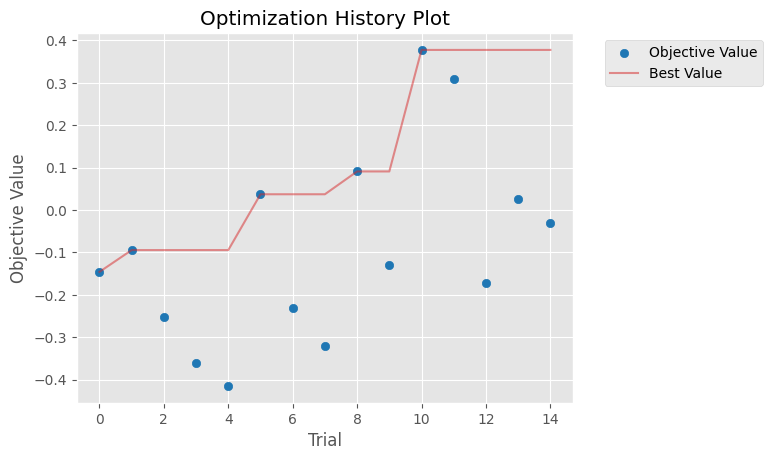

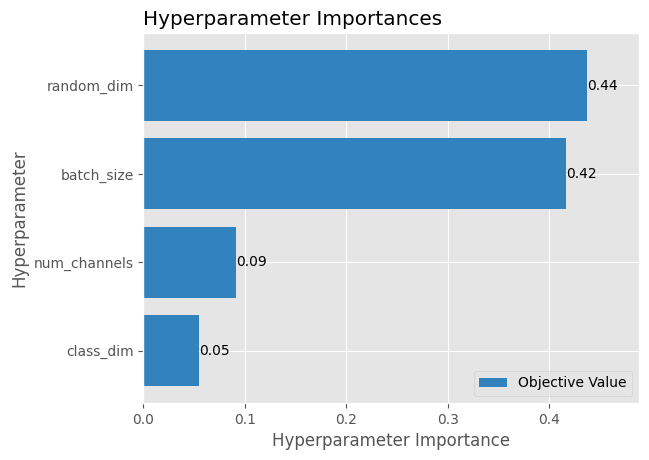

In [56]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
plot_optimization_history(study)
plot_param_importances(study)

In [57]:
def objective2(trial):
    batch_size = trial.suggest_categorical("batch_size", [64, 128])
    class_dim = trial.suggest_categorical("class_dim", [(64, 64), (64, 128)])
    random_dim = trial.suggest_int("random_dim", 90, 120)
    num_channels = trial.suggest_categorical("num_channels", [32, 64, 96])

    synthesizer = CTABGAN(
        raw_csv_path=real_path,
        test_ratio = 0.20,
        categorical_columns = categoricals, 
        log_columns = [],
        mixed_columns= {},
        general_columns = [],
        non_categorical_columns = [],
        integer_columns = integer_columns,
        problem_type= {"Classification": 'Label'},
        epochs=10,
        batch_size=batch_size,
        class_dim=class_dim,
        random_dim=random_dim,
        num_channels=num_channels
    )

    synthesizer.fit()
    syn = synthesizer.generate_samples()

    temp_path = "tmp_synth.csv"
    syn.to_csv(temp_path, index=False)

    util_scores = get_utility_metrics(real_path, [temp_path], "MinMax", ["lr"])[0]
    stat_scores = stat_sim(real_path, temp_path, categoricals)

    auc, f1 = util_scores[1], util_scores[2]
    jsd = stat_scores[1]
    corr = stat_scores[2]
    score = auc + f1 - 0.5 * jsd - 0.25 * abs(corr)

    return score

In [58]:
pruner = optuna.pruners.MedianPruner(n_startup_trials=3)
study2 = optuna.create_study(direction="maximize", study_name="ctabgan_optimization2", pruner=pruner)

[I 2025-06-14 16:09:51,686] A new study created in memory with name: ctabgan_optimization2


In [59]:
study2.optimize(objective, n_trials=15)

100%|██████████| 10/10 [00:14<00:00,  1.48s/it]


Finished training in 15.294857740402222  seconds.


[I 2025-06-14 16:10:20,693] Trial 0 finished with value: 0.33100207921783675 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 134, 'num_channels': 32}. Best is trial 0 with value: 0.33100207921783675.
100%|██████████| 10/10 [00:32<00:00,  3.30s/it]


Finished training in 33.54822850227356  seconds.


[I 2025-06-14 16:10:55,539] Trial 1 finished with value: -0.3143201247492554 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 108, 'num_channels': 64}. Best is trial 0 with value: 0.33100207921783675.
100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


Finished training in 33.614471673965454  seconds.


[I 2025-06-14 16:11:31,210] Trial 2 finished with value: 0.3775570321520987 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 128, 'num_channels': 64}. Best is trial 2 with value: 0.3775570321520987.
100%|██████████| 10/10 [01:18<00:00,  7.88s/it]


Finished training in 79.38776993751526  seconds.


[I 2025-06-14 16:12:54,686] Trial 3 finished with value: -0.21270670930386615 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 66, 'num_channels': 128}. Best is trial 2 with value: 0.3775570321520987.
100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


Finished training in 33.86149334907532  seconds.


[I 2025-06-14 16:13:30,545] Trial 4 finished with value: -0.2705766801660704 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 143, 'num_channels': 64}. Best is trial 2 with value: 0.3775570321520987.
100%|██████████| 10/10 [00:33<00:00,  3.31s/it]


Finished training in 33.65821886062622  seconds.


[I 2025-06-14 16:14:04,781] Trial 5 finished with value: -0.35484425749862347 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 137, 'num_channels': 64}. Best is trial 2 with value: 0.3775570321520987.
100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Finished training in 11.404813766479492  seconds.


[I 2025-06-14 16:14:17,091] Trial 6 finished with value: -0.10900685833450197 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 117, 'num_channels': 32}. Best is trial 2 with value: 0.3775570321520987.
100%|██████████| 10/10 [01:20<00:00,  8.08s/it]


Finished training in 81.43286085128784  seconds.


[I 2025-06-14 16:15:50,145] Trial 7 finished with value: -0.29354069325800336 and parameters: {'batch_size': 64, 'class_dim': (64, 64), 'random_dim': 118, 'num_channels': 128}. Best is trial 2 with value: 0.3775570321520987.
100%|██████████| 10/10 [01:20<00:00,  8.09s/it]


Finished training in 81.39610362052917  seconds.


[I 2025-06-14 16:17:14,023] Trial 8 finished with value: -0.29692930418718205 and parameters: {'batch_size': 64, 'class_dim': (128, 128), 'random_dim': 188, 'num_channels': 128}. Best is trial 2 with value: 0.3775570321520987.
100%|██████████| 10/10 [00:26<00:00,  2.60s/it]


Finished training in 26.570822715759277  seconds.


[I 2025-06-14 16:17:41,426] Trial 9 finished with value: 0.3132174240907196 and parameters: {'batch_size': 128, 'class_dim': (64, 64), 'random_dim': 112, 'num_channels': 64}. Best is trial 2 with value: 0.3775570321520987.
100%|██████████| 10/10 [00:26<00:00,  2.65s/it]


Finished training in 26.983064889907837  seconds.


[I 2025-06-14 16:18:10,752] Trial 10 finished with value: -0.15704159610745072 and parameters: {'batch_size': 128, 'class_dim': (128, 128), 'random_dim': 176, 'num_channels': 64}. Best is trial 2 with value: 0.3775570321520987.
100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Finished training in 11.529841661453247  seconds.


[I 2025-06-14 16:18:22,732] Trial 11 finished with value: 0.38108052795192315 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 155, 'num_channels': 32}. Best is trial 11 with value: 0.38108052795192315.
100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Finished training in 11.446569919586182  seconds.


[I 2025-06-14 16:18:34,595] Trial 12 finished with value: -0.03560697949713698 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 162, 'num_channels': 32}. Best is trial 11 with value: 0.38108052795192315.
100%|██████████| 10/10 [00:10<00:00,  1.08s/it]


Finished training in 11.324814558029175  seconds.


[I 2025-06-14 16:18:46,284] Trial 13 finished with value: 0.00013281177979340697 and parameters: {'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 163, 'num_channels': 32}. Best is trial 11 with value: 0.38108052795192315.
100%|██████████| 10/10 [00:11<00:00,  1.10s/it]


Finished training in 11.525242328643799  seconds.


[I 2025-06-14 16:18:58,266] Trial 14 finished with value: -0.3847081041340941 and parameters: {'batch_size': 256, 'class_dim': (128, 128), 'random_dim': 87, 'num_channels': 32}. Best is trial 11 with value: 0.38108052795192315.


In [60]:
print("Best parameters:")
print(study2.best_trial.params)

print("\nBest score:", study2.best_value)

Best parameters:
{'batch_size': 256, 'class_dim': (64, 64), 'random_dim': 155, 'num_channels': 32}

Best score: 0.38108052795192315


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

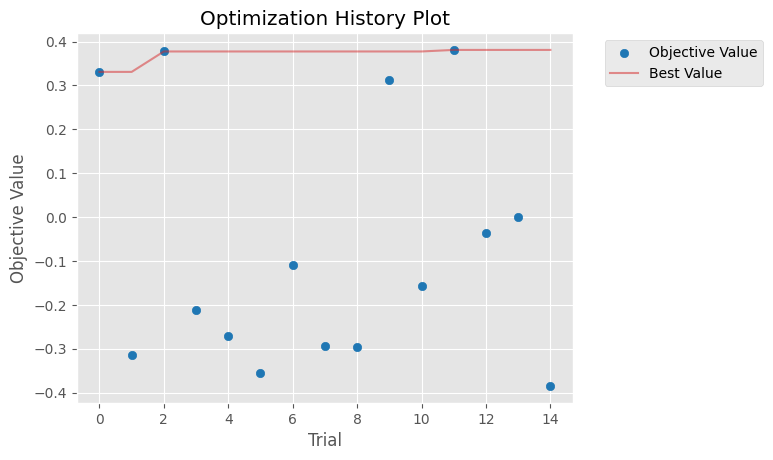

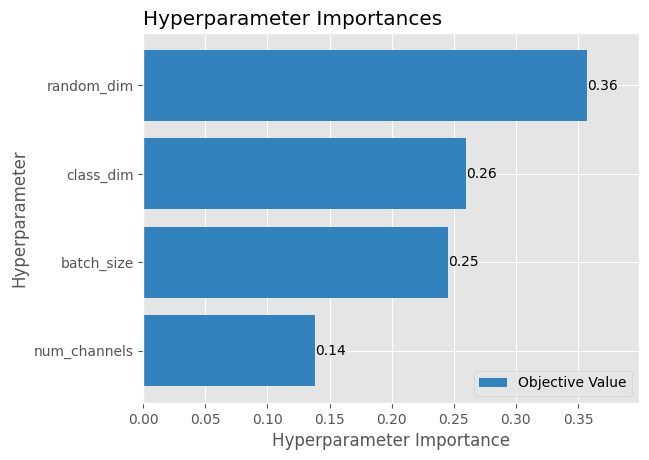

In [61]:
from optuna.visualization.matplotlib import plot_optimization_history, plot_param_importances
plot_optimization_history(study2)
plot_param_importances(study2)

In [62]:
import shutil

shutil.move("./tmp_synth.csv", "Fake_Datasets/fake_best.csv")

'Fake_Datasets/fake_best.csv'

In [75]:
classifiers_list = ["lr","dt","rf","mlp"]
result_mat = get_utility_metrics(real_path,[fake_best_path],"MinMax",classifiers_list, test_ratio = 0.20)

result_df  = pd.DataFrame(result_mat,columns=["Acc","AUC","F1_Score"])
result_df.index = classifiers_list
result_df

,Acc,AUC,F1_Score
lr,11.00,0.109683,0.423932
dt,40.75,0.474486,0.505358
rf,14.25,0.181292,0.230499
mlp,11.75,0.268073,0.441863


In [64]:
stat_res = stat_sim(real_path,fake_best_path,categoricals)


stat_columns = ["Average WD (Continuous Columns)","Average JSD (Categorical Columns)","Correlation Distance"]
stat_results = pd.DataFrame(np.array(stat_res).reshape(1,3),columns=stat_columns)
stat_results

,Average WD (Continuous Columns),Average JSD (Categorical Columns),Correlation Distance
0,0.087336,0.177282,3.318727


In [65]:
priv_res = privacy_metrics(real_path,fake_best_path)
    
privacy_columns = ["DCR between Real and Fake (5th perc)","DCR within Real(5th perc)","DCR within Fake (5th perc)","NNDR between Real and Fake (5th perc)","NNDR within Real (5th perc)","NNDR within Fake (5th perc)"]
privacy_results = pd.DataFrame(np.array(priv_res).reshape(1,6),columns=privacy_columns)
privacy_results

,DCR between Real and Fake (5th perc),DCR within Real(5th perc),DCR within Fake (5th perc),NNDR between Real and Fake (5th perc),NNDR within Real (5th perc),NNDR within Fake (5th perc)
0,1.061691,0.000002,0.492928,0.733416,0.010246,0.505111


In [66]:
def plot_correlation_matrices(real_df, synth_df):
    real_corr = real_df.corr()
    synth_corr = synth_df.corr()

    fig, axs = plt.subplots(1, 2, figsize=(24, 12))
    sns.heatmap(real_corr, ax=axs[0], cmap="coolwarm", annot=True)
    axs[0].set_title("Real Data Correlation")

    sns.heatmap(synth_corr, ax=axs[1], cmap="coolwarm", annot=True)
    axs[1].set_title("Synthetic Data Correlation")

    plt.tight_layout()
    plt.show()

real_df = pd.read_csv(real_path)
fake_df = pd.read_csv(fake_path)
fake_best_df = pd.read_csv(fake_best_path)

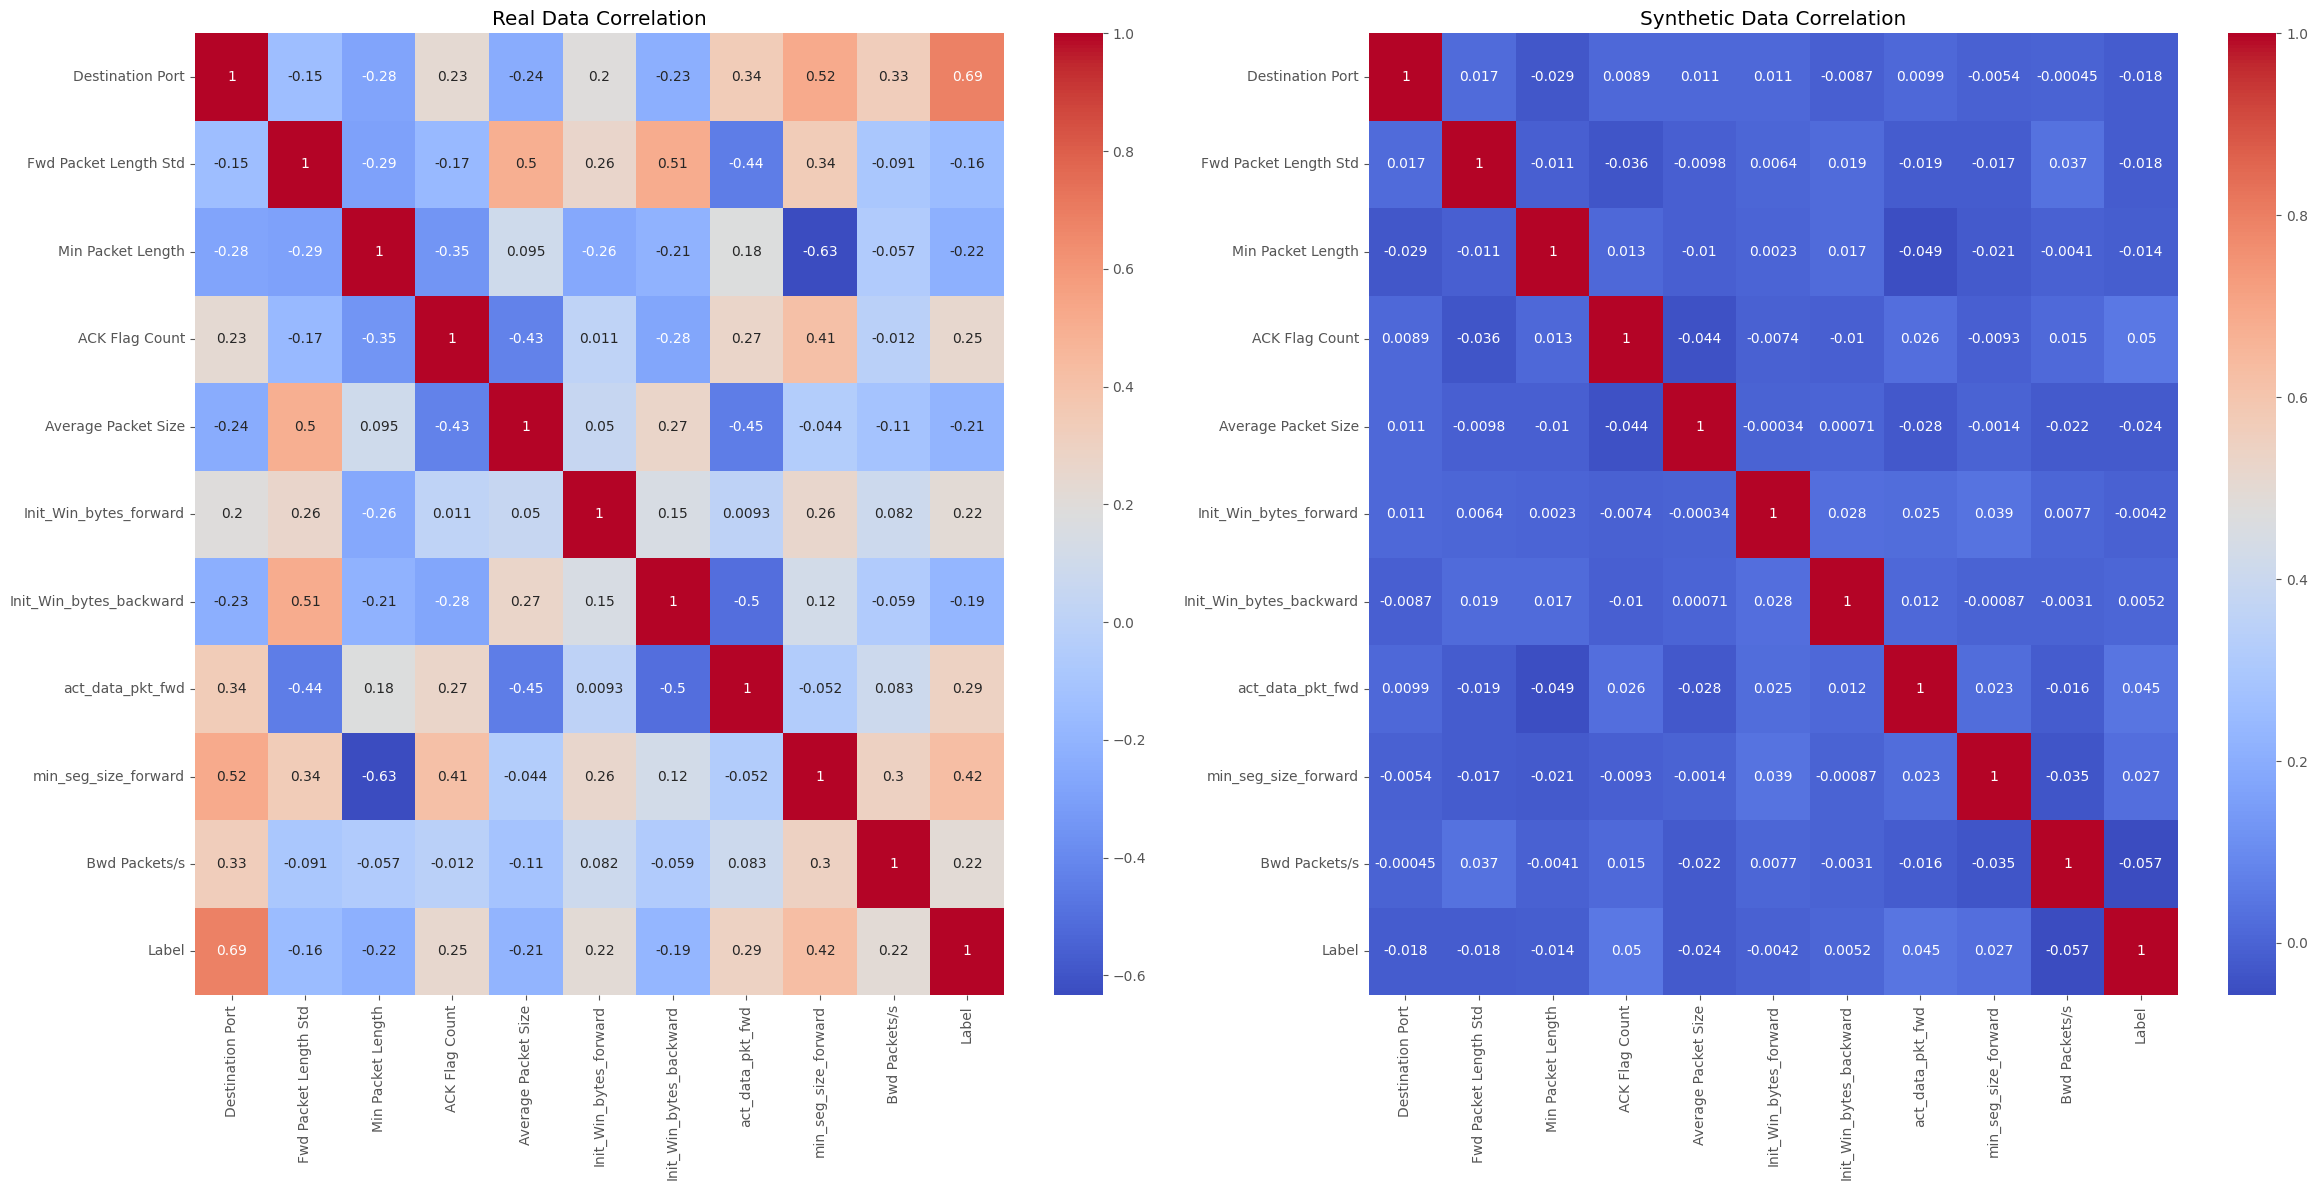

In [67]:
plot_correlation_matrices(real_df, fake_df)

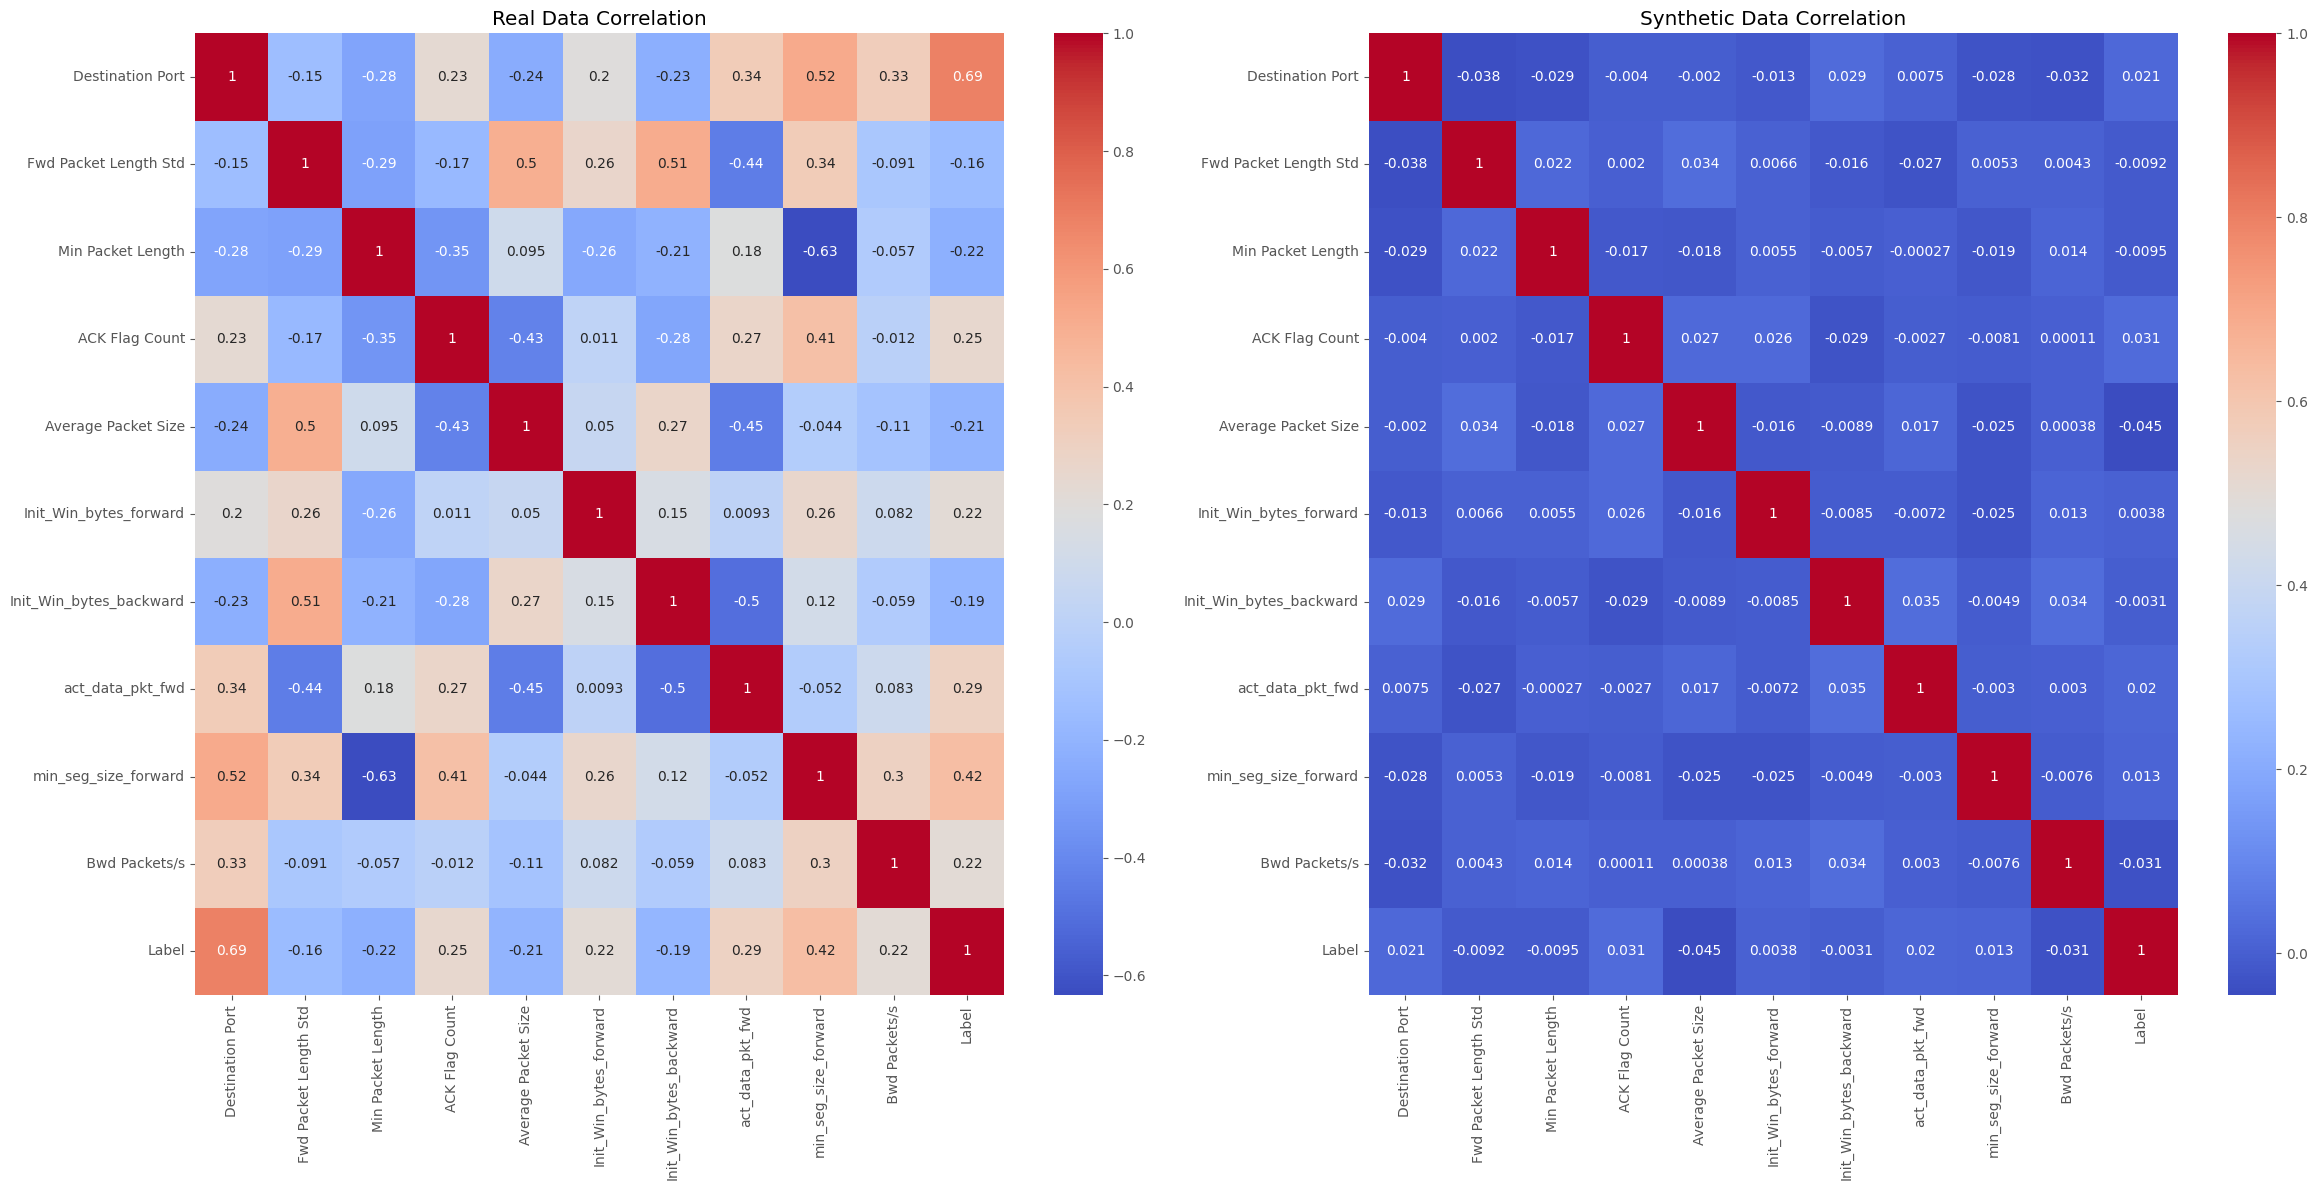

In [68]:
plot_correlation_matrices(real_df, fake_best_df)

In [69]:
def kolmogorov_smirnov_test(real_df, synth_df, columns):
    ks_results = {}
    for col in columns:
        if real_df[col].dtype.kind in 'iuf':
            stat, pval = ks_2samp(real_df[col], synth_df[col])
            ks_results[col] = {"KS_statistic": stat, "p_value": pval}
    return ks_results

In [70]:
print("Initial:")
print(kolmogorov_smirnov_test(real_df, fake_df, real_df.columns))
print("Best:")
print(kolmogorov_smirnov_test(real_df, fake_best_df, real_df.columns))

Initial:
{'Destination Port': {'KS_statistic': 0.6145, 'p_value': 0.0}, 'Fwd Packet Length Std': {'KS_statistic': 0.581, 'p_value': 8.9642639508e-313}, 'Min Packet Length': {'KS_statistic': 0.153, 'p_value': 7.821553991571827e-21}, 'ACK Flag Count': {'KS_statistic': 0.1385, 'p_value': 3.8910250950483934e-17}, 'Average Packet Size': {'KS_statistic': 0.319, 'p_value': 2.3560953672338372e-90}, 'Init_Win_bytes_forward': {'KS_statistic': 0.3365, 'p_value': 1.0694775877664045e-100}, 'Init_Win_bytes_backward': {'KS_statistic': 0.587, 'p_value': 9.7015e-320}, 'act_data_pkt_fwd': {'KS_statistic': 0.2735, 'p_value': 3.237665997158661e-66}, 'min_seg_size_forward': {'KS_statistic': 0.217, 'p_value': 1.2114771923319686e-41}, ' Bwd Packets/s': {'KS_statistic': 0.6255, 'p_value': 0.0}, 'Label': {'KS_statistic': 0.0085, 'p_value': 0.9999996505763133}}
Best:
{'Destination Port': {'KS_statistic': 0.4965, 'p_value': 2.7821616698527406e-224}, 'Fwd Packet Length Std': {'KS_statistic': 0.588, 'p_value': 6.5

In [71]:
def scatter_plot_comparison(real_df, synth_df, features):
    for col in features:
        if real_df[col].dtype.kind in 'iuf':
            plt.figure(figsize=(10, 5))
            plt.scatter(real_df.index, real_df[col], alpha=0.4, label="Real", s=10)
            plt.scatter(synth_df.index, synth_df[col], alpha=0.4, label="Synthetic", s=10)
            plt.title(f"Scatter Plot of Feature: {col}")
            plt.legend()
            plt.show()

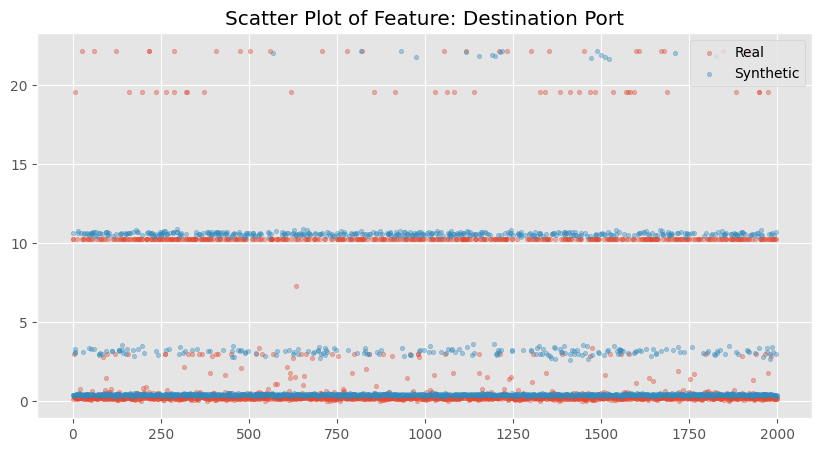

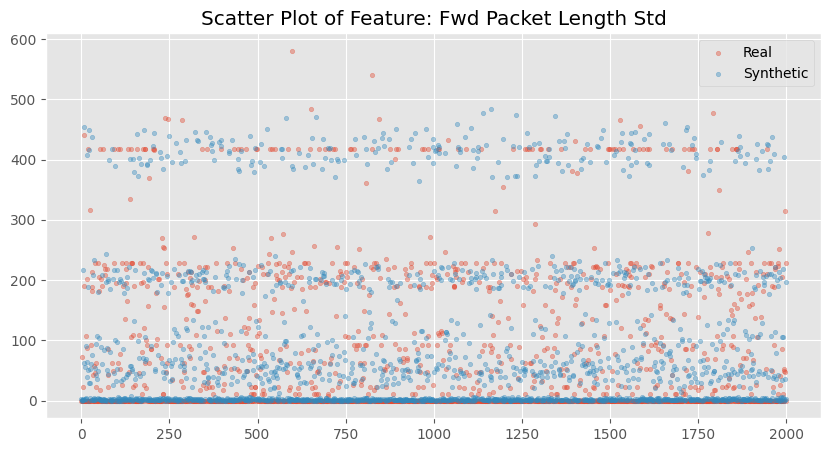

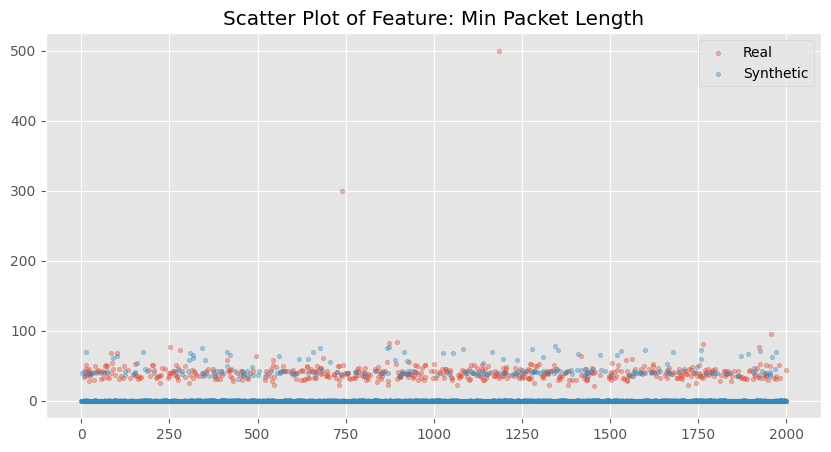

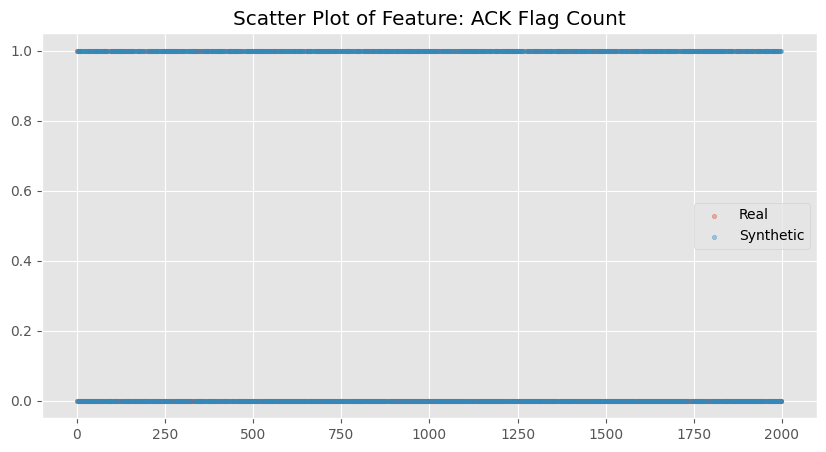

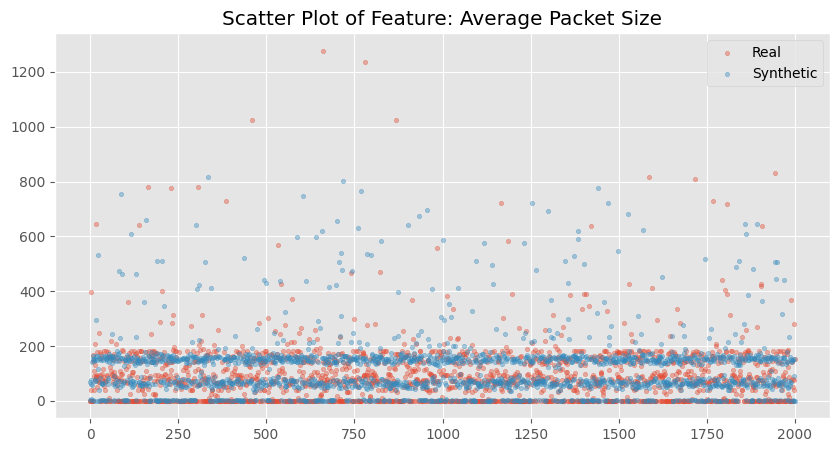

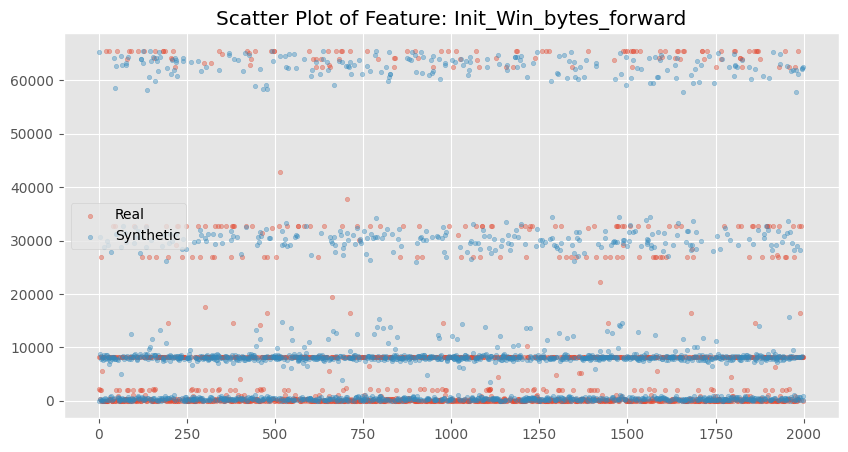

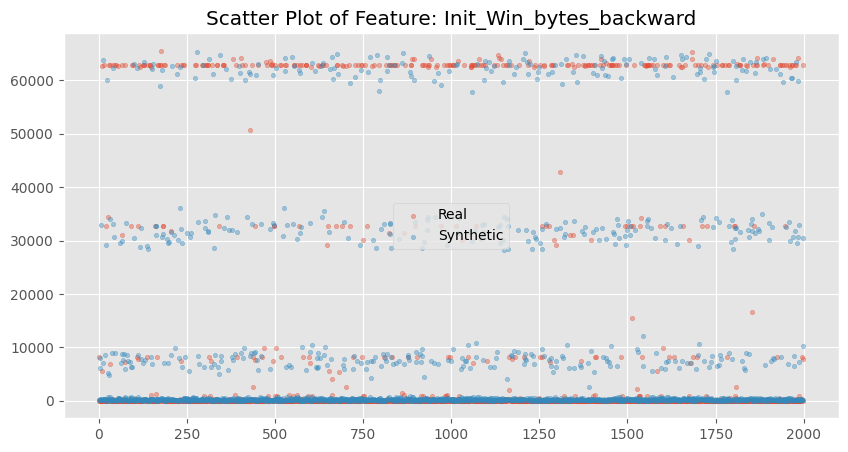

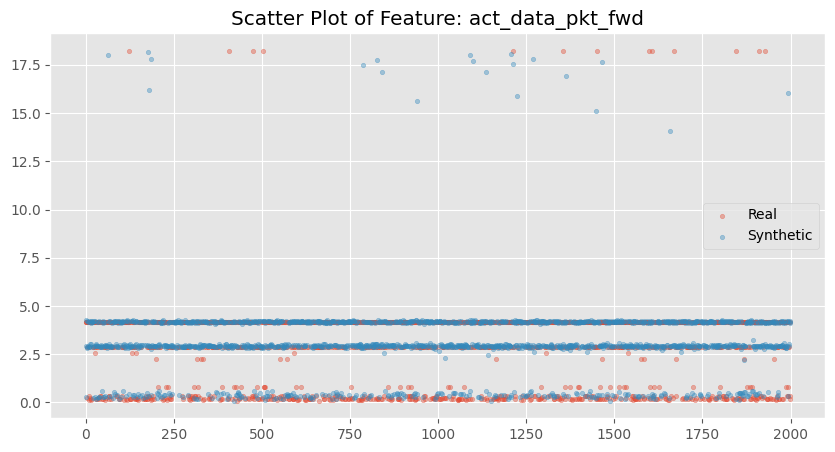

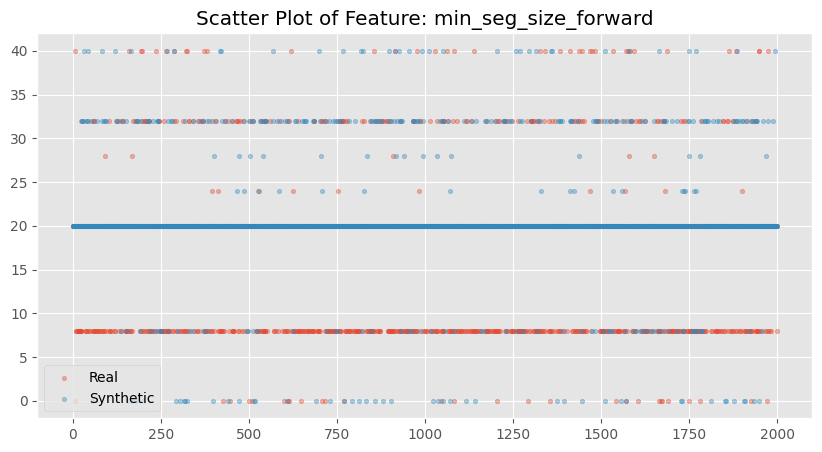

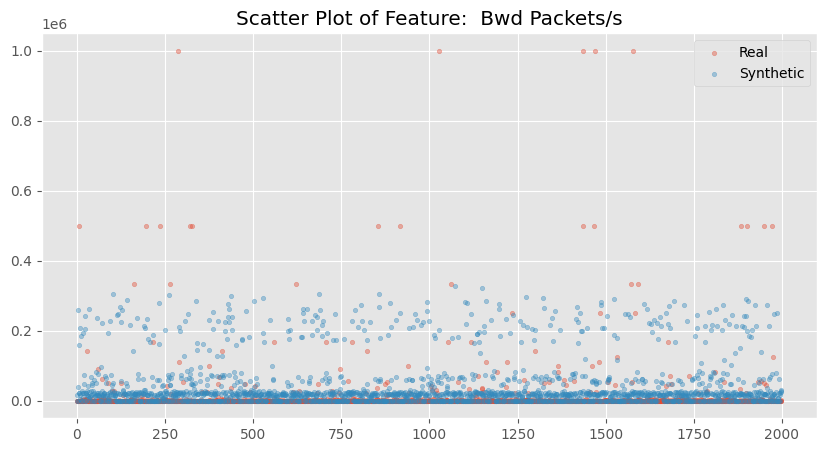

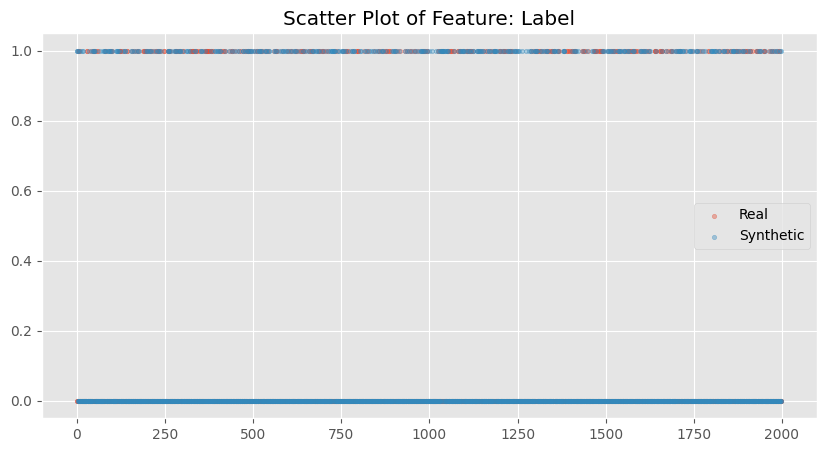

In [72]:
scatter_plot_comparison(real_df, fake_df, real_df.columns)

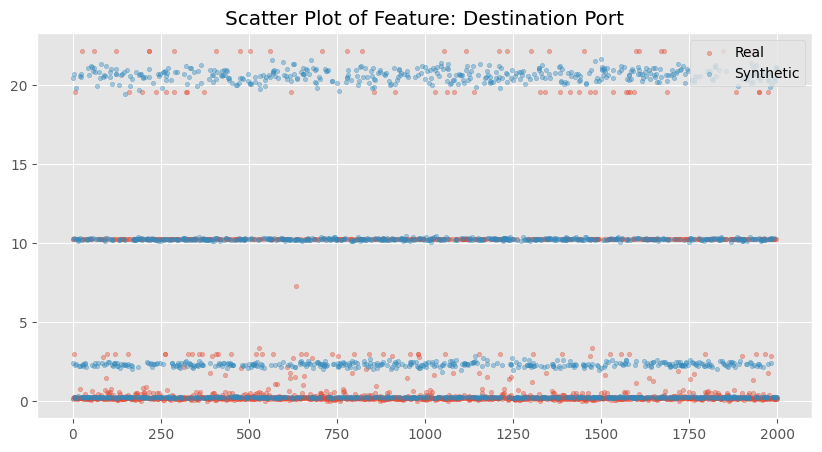

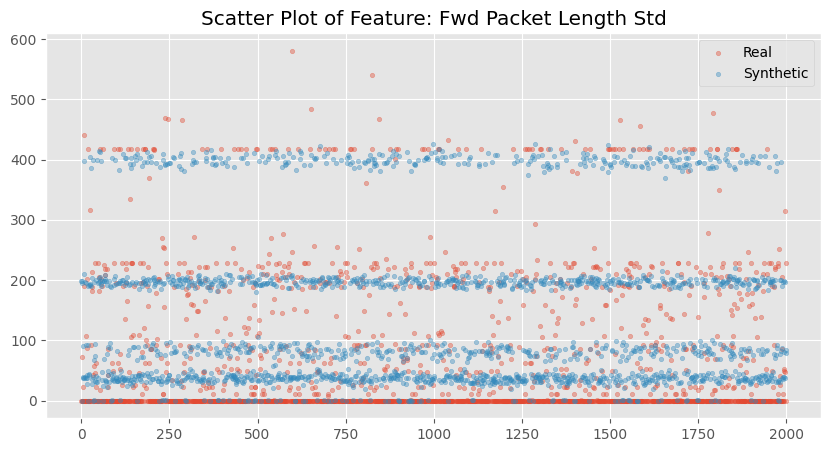

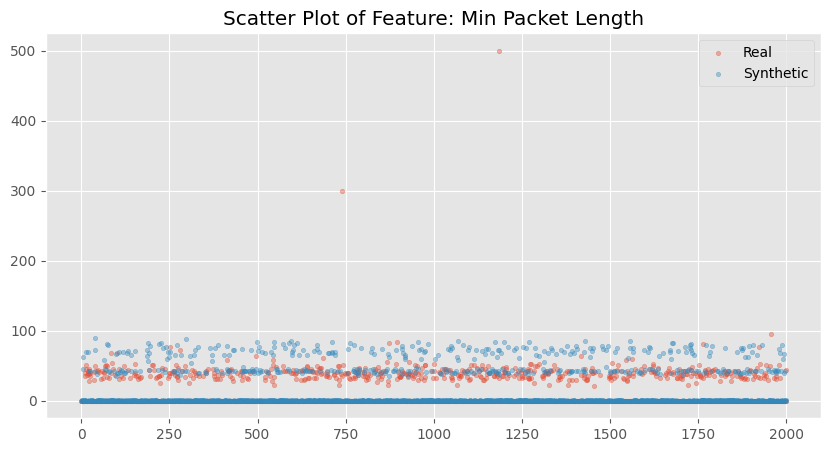

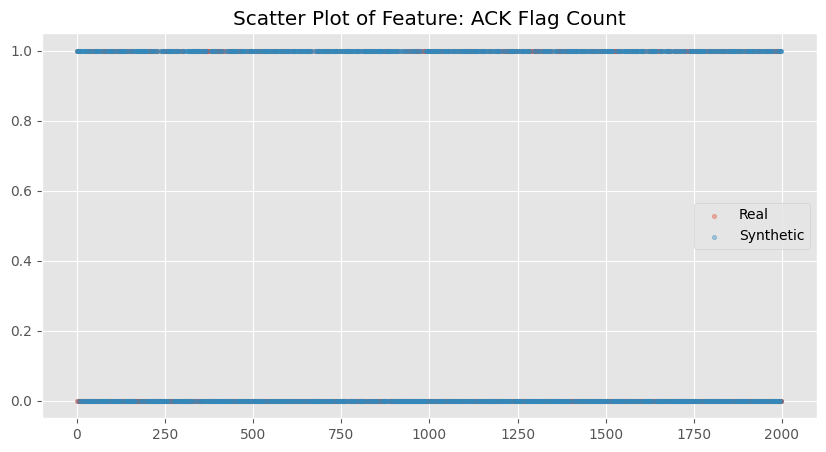

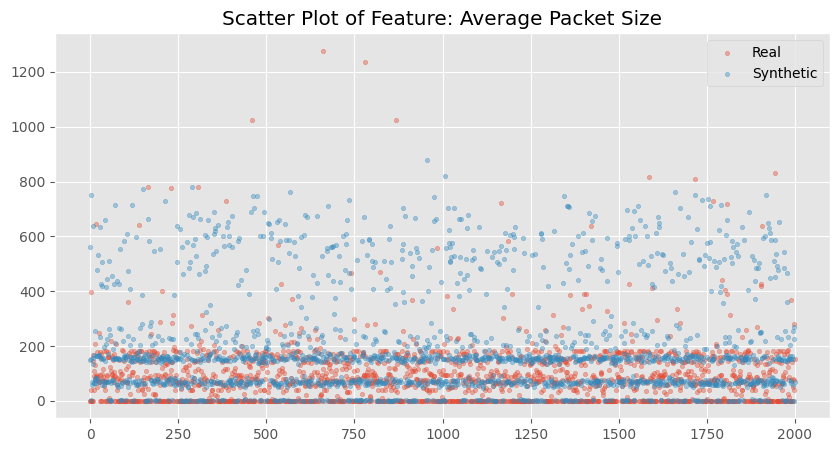

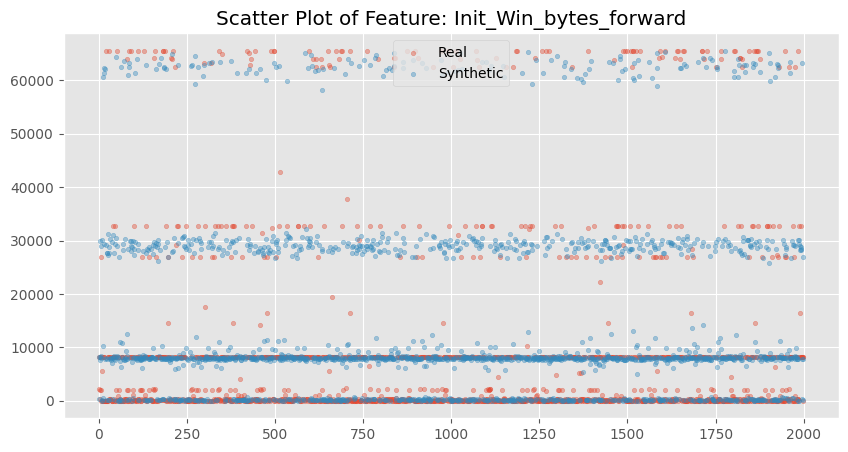

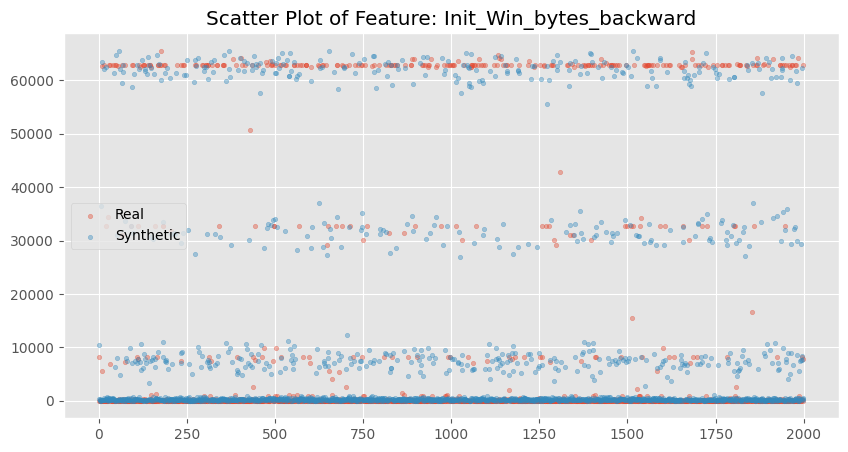

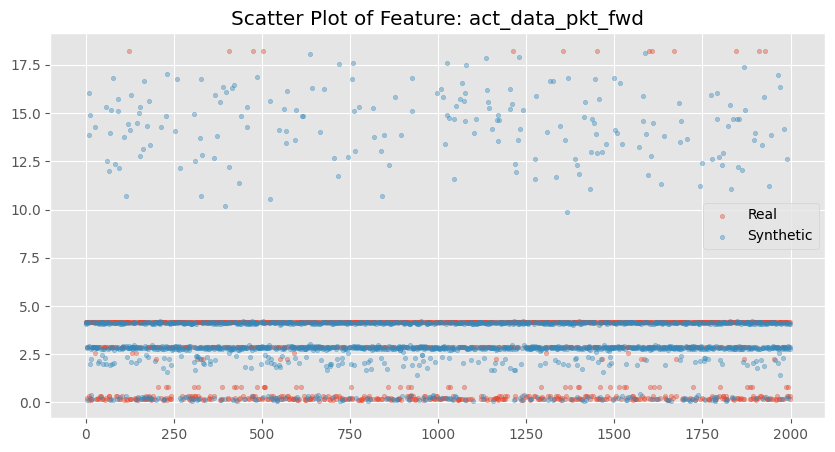

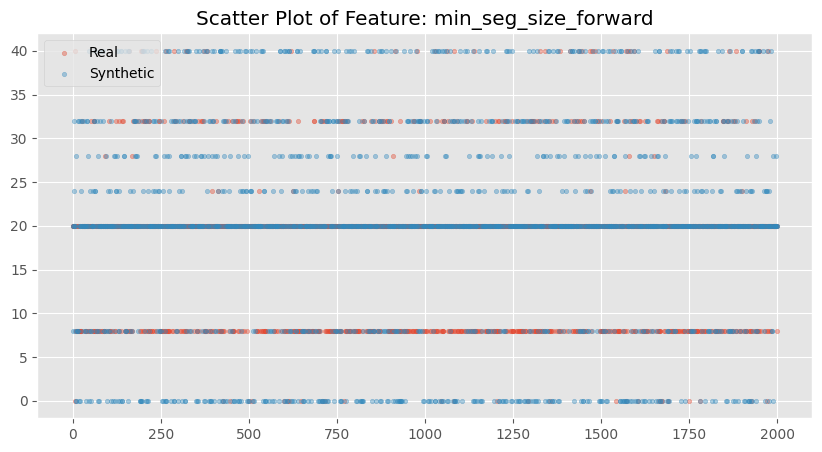

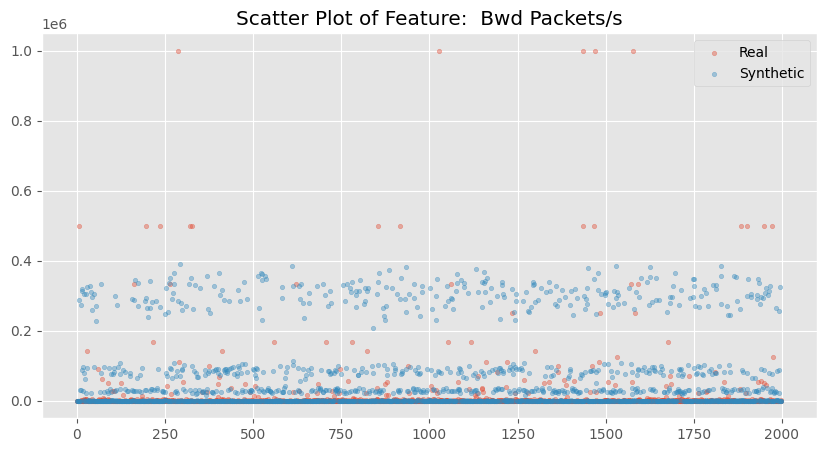

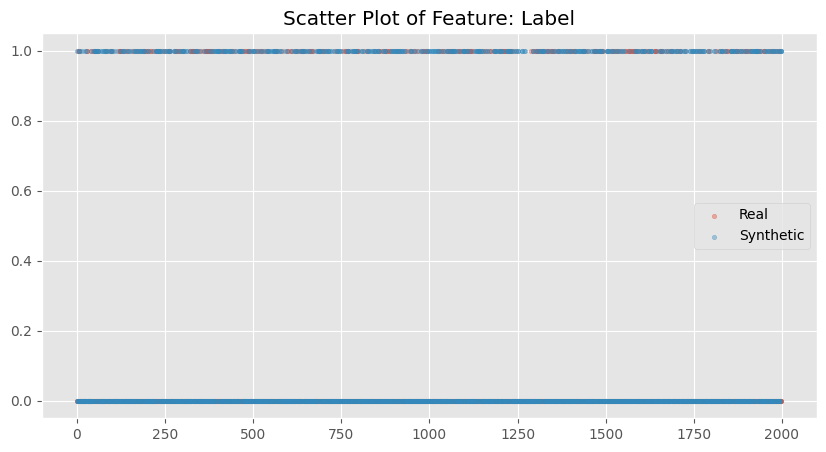

In [76]:
scatter_plot_comparison(real_df, fake_best_df, real_df.columns)

In [74]:
initial = pd.DataFrame({
    "Classifier": ["LR", "DT", "RF", "MLP"],
    "AUC": [0.194329, 0.364678, 0.221771, 0.345382],
    "F1 Score": [0.423932, 0.374663, 0.198011, 0.441863]
}).set_index("Classifier")

optimized = pd.DataFrame({
    "Classifier": ["LR", "DT", "RF", "MLP"],
    "AUC": [0.109683, 0.474486, 0.181292, 0.268073],
    "F1 Score": [0.423932, 0.505358, 0.230499, 0.441863]
}).set_index("Classifier")

percentage_improvement = ((optimized - initial) / initial) * 100
percentage_improvement = percentage_improvement.round(2)

print(percentage_improvement)


              AUC  F1 Score
Classifier                 
LR         -43.56      0.00
DT          30.11     34.88
RF         -18.25     16.41
MLP        -22.38      0.00
